In [ ]:
%pip install seaborn[stats]

# UWF* datasets stats

This notebook explores the data from the UWF22 dataset

In this notebook, we explore:
- Basic dataset stats


### Prepare the dataset

Run the preparation for the dataset with the `prepare_data` and `setup` methods.

In [1]:
from datasets.UWF22H_local import UWF22 as UWF22H
from datasets.UWF import UWF22, UWF22Fall, UWF24, UWF24Fall
from datasets.UWF_Shuffled import UWF22 as UWF22S
from ordered_set import OrderedSet

possible_datasets = ["UWF22", "UWF22h", "UWF22Fall", "UWF24", "UWF24Fall"]

/data/Try1/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

class KeyMapGen():
    # Exclude the mapping for the following columns
    exclude_columns = [
        "ts",
        "src_ip_id",
        "src_ip_zeek",
        "dest_ip_id",
        "dest_ip_zeek",
        "src_service_id",
        "dest_service_id"
    ]

    def __init__(self, dataset, output_folder) -> None:
        self.dataset = dataset
        self.output_folder = output_folder
        self.key_file = os.path.join(self.output_folder, f"{dataset.dataset_name}_keywordmap_percent.parquet")
        self.first_batch_passed = False

    def generate_maps(self, columns):

        self.keyword_map = {col: OrderedSet([]) for col in columns if col not in self.exclude_columns}
        self.hostmap = OrderedSet([])
        self.usermap = OrderedSet([])

        # Keep track of the added values per column
        self.added_items_per_bin = {col: [] for col in columns if col not in self.exclude_columns}
        self.added_items_per_bin["hosts"] = []
        self.added_items_per_bin["services"] = []
        self.added_items_per_bin["stage"] = []

    def count_updates(self, ordered_set: OrderedSet, update):
        set_size = len(ordered_set)
        ordered_set.update(update)
        new_size = len(ordered_set)
        return new_size - set_size

    def process_batch(self, batch, stage):
        # If this is the first batch, generate the maps as well
        if not self.first_batch_passed:
            columns = list(batch[0].columns)
            self.generate_maps(columns)
            self.first_batch_passed = True

        # Go trough every bin
        for bin in batch:
            # Update keyword map
            for col in self.keyword_map.keys():
                diff = self.count_updates(self.keyword_map[col], bin[col].dropna().unique())
                self.added_items_per_bin[col].append(diff)
            
            diff1 = self.count_updates(self.hostmap, bin["src_ip_id"].dropna().unique())
            diff2 = self.count_updates(self.hostmap, bin["dest_ip_id"].dropna().unique())
            self.added_items_per_bin["hosts"].append(diff1 + diff2)

            diff1 = self.count_updates(self.usermap, bin["src_service_id"].dropna().unique())
            diff2 = self.count_updates(self.usermap, bin["dest_service_id"].dropna().unique())
            self.added_items_per_bin["services"].append(diff1 + diff2)

            self.added_items_per_bin["stage"].append(stage)

    def compute(self):
        # If not batches have been processed
        if not self.first_batch_passed:
            return pd.DataFrame([])

        df = pd.DataFrame(self.added_items_per_bin)
        return df
    
    def save(self):
        df = pd.DataFrame(self.added_items_per_bin)
        df.to_parquet(self.key_file)
        return df
    
    def saveplots(self, cols = ["hosts"]):
        df = self.compute()

        # Generate global
        self.plot_hosts_no_stage(df, cols).savefig(os.path.join(self.output_folder, f"{self.dataset.dataset_name}_global.svg"))
        # Generate with stage
        self.plot_hosts_with_stage(df, cols).savefig(os.path.join(self.output_folder, f"{self.dataset.dataset_name}_stage.svg"))

    
    def showplots(self, cols = ["hosts"]):
        df = pd.read_parquet(self.key_file)

        # Generate global
        self.plot_hosts_no_stage(df, cols).savefig(os.path.join(self.output_folder, f"{self.dataset.dataset_name}_global.svg"))
        # Generate with stage
        self.plot_hosts_with_stage(df, cols).savefig(os.path.join(self.output_folder, f"{self.dataset.dataset_name}_stage.svg"))

    def plot_hosts_no_stage(self, df, cols = ["hosts"]):
        clear_output(wait=True)
        df.index = df.index/self.dataset.batch_size
        ax = df[cols].cumsum().plot(xlabel="batch", ylabel="Unique count")
        plt.title(f"{self.dataset.dataset_name} Unique {cols}")
        plt.grid(True)
        
        return plt

    def plot_hosts_with_stage(self, df: pd.DataFrame, cols = ["hosts"]):
        # Sort by stage
        df.index.name = "index"
        df = df.sort_values(["stage", "index"])
        df = df.reset_index(drop=True)

        clear_output(wait=True)
        plt.figure(figsize=(10, 5))

        # Plot the data
        df.index = df.index/self.dataset.batch_size
        ax = df[cols].cumsum().plot(xlabel="batch", ylabel="Unique count")

        # Get unique stages and their x ranges
        for stage, group in df.groupby("stage"):
            x_start = group.index.min()
            x_end = group.index.max()

            stage_label = "Training"
            color = (0,1,0)
            if stage == 1:
                stage_label = "Validation"
                color = (1,1,0)
            if stage == 2:
                stage_label = "Testing"
                color = (1,0,0)

            plt.axvspan(x_start, x_end, alpha=0.2, label=stage_label, color=color)

        plt.title(f"{self.dataset.dataset_name} Unique values by Stage")
        plt.legend()
        plt.grid(True)
        
        return plt

In [3]:
from tqdm.auto import tqdm

class EventCount():
    def __init__(self, dataset, ouput_folder) -> None:
        self.dataset = dataset
        self.ouput_folder = ouput_folder
        self.event_count = 0

    def process_batch(self, batch, stage):
        # Go trough every bin
        for bin in batch:
            # Count the events
            self.event_count += len(bin)

    def compute(self):
        return self.event_count

def database_to_df(dataset):
    dataset.prepare_data()
    dataset.setup(stage="fit")

    df = pd.DataFrame([])

    for file in tqdm(dataset.download_data, f"Loading {dataset.dataset_name}"):
        filename = os.path.join(dataset.data_dir, file["raw_file"])
        part = pd.read_parquet(filename)
        df = pd.concat([df, part])
        
    # Create bins
    df['bin'] = df['ts'] // dataset.bin_size

    # Rearrange bins to be sequential
    bin_map = {
        value: id
        for id, value in enumerate(df["bin"].unique())
        }
    df["bin"] = df["bin"].map(bin_map)

    # Create batches
    df["batch"] = df["bin"] // dataset.batch_size
    
    return df

In [4]:
dataset_folder = "/data/datasets/"

uwf22 = database_to_df(UWF22S(dataset_folder, shuffle=False))
uwf22Fall = database_to_df(UWF22Fall(dataset_folder))
uwf24 = database_to_df(UWF24(dataset_folder))
uwf24Fall = database_to_df(UWF24Fall(dataset_folder))
uwf22_shuffled = database_to_df(UWF22S(dataset_folder, shuffle_bin_size=0.1, shuffle_every_time=True, shuffle_type="random"))

Loading UWF22: 100%|██████████| 8/8 [00:17<00:00,  2.19s/it]
/data/Try1/.venv/lib/python3.12/site-packages/torch/utils/data/dataset.py:469: UserWarning: Length of split at index 2 is 0. This might result in an empty dataset.
  warnings.warn(
/data/Try1/.venv/lib/python3.12/site-packages/torch/utils/data/dataset.py:469: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(
Loading UWF24: 100%|██████████| 7/7 [00:01<00:00,  3.84it/s]
/data/Try1/.venv/lib/python3.12/site-packages/torch/utils/data/dataset.py:469: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(
/data/Try1/.venv/lib/python3.12/site-packages/torch/utils/data/dataset.py:469: UserWarning: Length of split at index 2 is 0. This might result in an empty dataset.
  warnings.warn(
Loading UWF24Fall: 100%|██████████| 9/9 [00:04<00:00,  2.04it/s]
/data/Try1/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarnin

# Basic Dataset Stats

In [5]:
uwf22.columns

Index(['resp_pkts', 'service', 'orig_ip_bytes', 'local_resp', 'missed_bytes',
       'proto', 'duration', 'conn_state', 'dest_ip_zeek', 'orig_pkts',
       'community_id', 'resp_ip_bytes', 'dest_port_zeek', 'orig_bytes',
       'local_orig', 'datetime', 'history', 'resp_bytes', 'uid',
       'src_port_zeek', 'ts', 'src_ip_zeek', 'label_tactic', 'bin', 'batch'],
      dtype='object')

In [ ]:
data = []

for dataset_df, dataset_name in [(uwf22, "UWF22"), (uwf22Fall, "UWF22Fall"), (uwf24, "UWF24")]:
    first_event = dataset_df["datetime"].min()
    last_event = dataset_df["datetime"].max()
    length = dataset_df["datetime"].max() - dataset_df["datetime"].min()
    events = len(dataset_df)

    hostset = OrderedSet([])
    hostset.update(dataset_df["src_ip_zeek"].fillna("None").unique()) # type: ignore
    hostset.update(dataset_df["dest_ip_zeek"].fillna("None").unique()) # type: ignore

    data.append({
        "name": dataset_name,
        "first_event": first_event,
        "last_event": last_event,
        "length": length,
        "events": events,
        "unique_hosts": len(hostset)
    })
    
data = pd.DataFrame(data)
print(data)

# Violin plots

In [ ]:
import numpy as np

def preprocess(df, dataset):
    df["mal"] = df["label_tactic"] != "none"
    df['ts_log'] = np.log1p(df['ts'])  # log transform
    df["dataset"] = dataset

    return df

uwf22 = preprocess(uwf22, "UWF22")
uwf22Fall = preprocess(uwf22Fall, "UWF22Fall")
uwf24 = preprocess(uwf24, "UWF24")
uwf24Fall = preprocess(uwf24Fall, "UWF24Fall")
uwf22s = preprocess(uwf22_shuffled, "UWF22 Shuffled")

all_datasets = pd.concat([uwf22, uwf22Fall, uwf24, uwf24Fall])

In [ ]:
import seaborn as sns
fig = sns.violinplot(data=all_datasets, x="dataset", y="bin", hue="mal", fill=True)
fig.get_figure().savefig("violins_all_datasets.svg")

NameError: name 'all_datasets' is not defined

# Comparing random shuffling

In [ ]:
uwf22_shuffled_day = database_to_df(UWF22S(dataset_folder, shuffle_bin_size=0.1, shuffle_every_time=True, shuffle_type="day"))
uwf22_shuffled_random = database_to_df(UWF22S(dataset_folder, shuffle_bin_size=0.1, shuffle_every_time=True, shuffle_type="random"))
uwf22_shuffled_random5 = database_to_df(UWF22S(dataset_folder, shuffle_bin_size=5, shuffle_every_time=True, shuffle_type="random"))
uwf22_shuffled_random400 = database_to_df(UWF22S(dataset_folder, shuffle_bin_size=400, shuffle_every_time=True, shuffle_type="random"))

In [ ]:
def preprocess(df, dataset):
    df["mal"] = df["label_tactic"] != "none"
    df['ts_log'] = np.log1p(df['ts'])  # log transform
    df["dataset"] = dataset

    return df

uwf22_shuffled_day = preprocess(uwf22_shuffled_day, "UWF22 Shuffled (Day)")
uwf22_shuffled_random = preprocess(uwf22_shuffled_random, "UWF22 Shuffled (Random 0.1)")
uwf22_shuffled_random5 = preprocess(uwf22_shuffled_random5, "UWF22 Shuffled (Random 5)")
uwf22_shuffled_random400 = preprocess(uwf22_shuffled_random400, "UWF22 Shuffled (Random 400)")

shuffling_datasets = pd.concat([uwf22_shuffled_random, uwf22_shuffled_random5, uwf22_shuffled_random400])

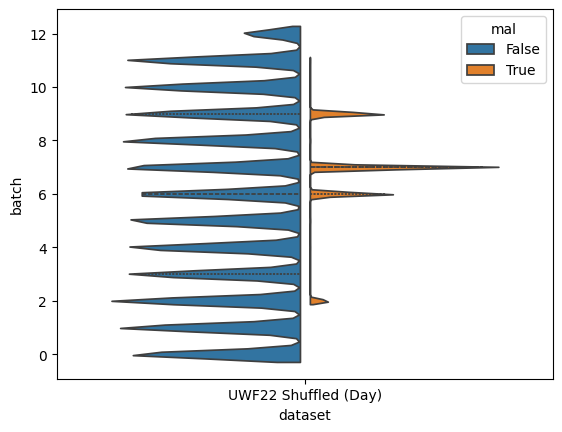

In [11]:
import seaborn as sns
fig = sns.violinplot(data=uwf22_shuffled_day, x="dataset", y="batch", hue="mal", split=True, gap=.05, fill=True, inner="quart")
fig.get_figure().savefig("violins_shuffle_day.svg")

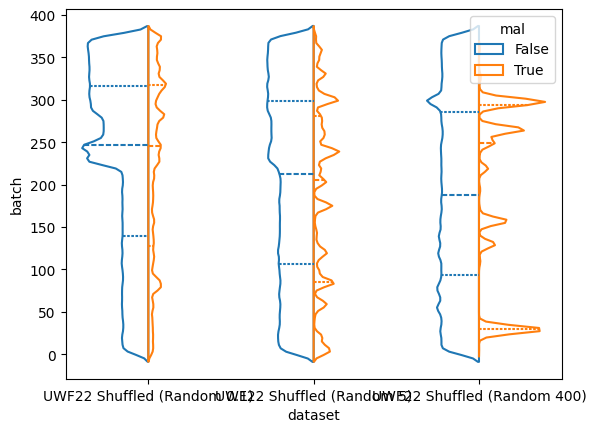

In [10]:
import seaborn as sns
fig = sns.violinplot(data=shuffling_datasets, x="dataset", y="batch", hue="mal", fill=False, split=True, inner="quart")
fig.get_figure().savefig("violins_shuffle_random.svg")

# Edge label per batch

In [44]:
def plot_area(grouped_df, savefile=None):
    grouped_unstacked = grouped_df.unstack(fill_value=0)

    # Step 3: Sort bins (important for cumulative sum and plotting)
    grouped_unstacked = grouped_unstacked.sort_index()

    # Step 4: Compute cumulative sum
    cumulative = grouped_unstacked.cumsum()

    # Step 5: Plot area chart
    cumulative.plot(kind='area', figsize=(10, 6), stacked=True)
    plt.xlabel('Batch')
    plt.ylabel('Cumulative Count')
    plt.title('Cumulative Category Counts per Batch (Area Chart)')
    plt.legend(title='Category')
    plt.tight_layout()
    if savefile is not None:
        plt.savefig(savefile)
    else:
        plt.show()

def plot_bar(grouped_df):
    grouped_unstacked = grouped_df.unstack(fill_value=0)

    # Step 3: Sort bins (important for cumulative sum and plotting)
    grouped_unstacked = grouped_unstacked.sort_index()

    # Step 4: Compute cumulative sum
    cumulative = grouped_unstacked.sum()

    # Step 5: Plot area chart
    cumulative.plot(kind='line', figsize=(10, 6), stacked=True)
    plt.xlabel('Batch')
    plt.ylabel('Count')
    plt.title('Category Counts per Batch (Area Chart)')
    plt.legend(title='Category')
    plt.tight_layout()
    plt.show()

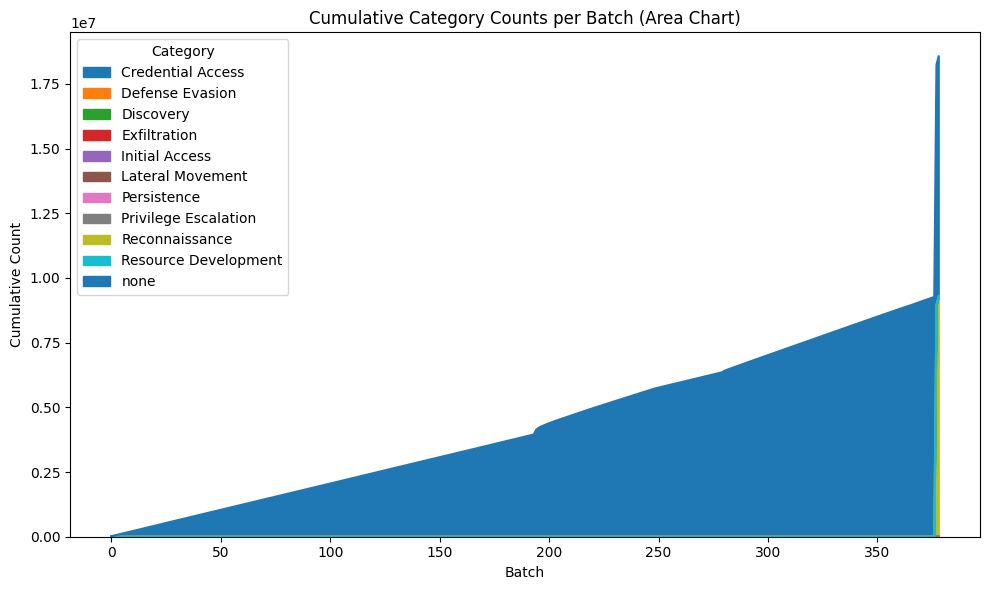

In [ ]:
grouped = uwf22.groupby(['batch', 'label_tactic']).size()
plot_area(grouped, "area_malicious_events.svg")

# Take a closer look at the malicious events

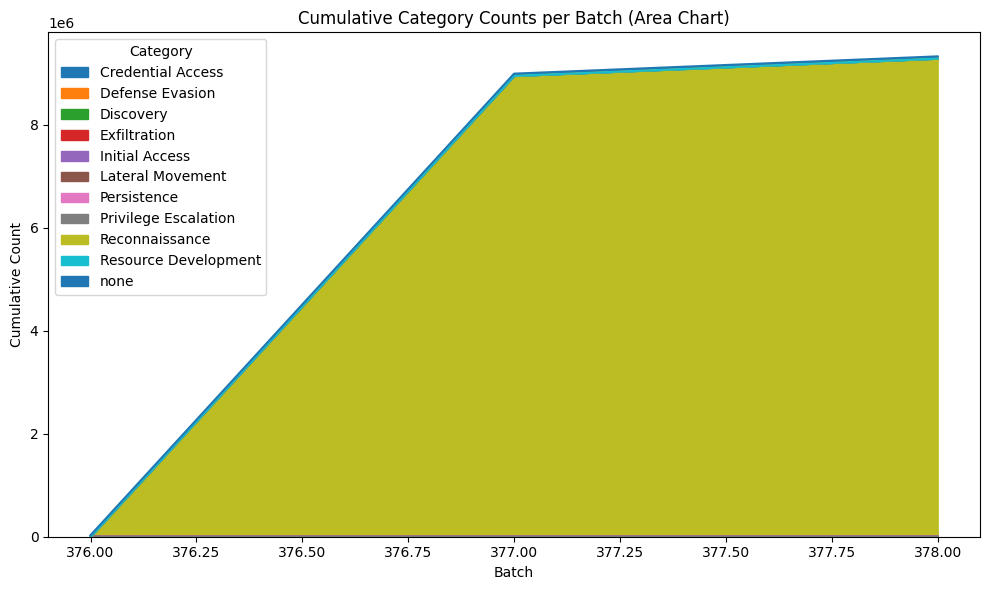

In [ ]:
grouped = uwf22[uwf22["batch"] > 375].groupby(['batch', 'label_tactic']).size()
plot_area(grouped, "area_malicious_events_closeup.svg")

# Testing Shuffling per bin

/data/Try1/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
Loading UWF22_Shuffled: 100%|██████████| 8/8 [00:13<00:00,  1.65s/it]


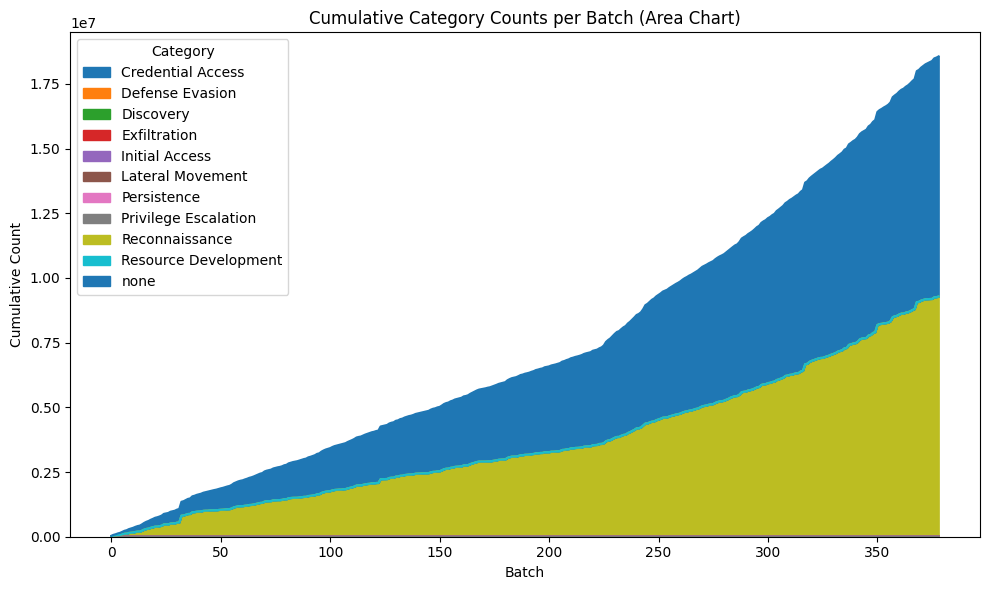

In [45]:
uwf22_shuffled = database_to_df(UWF22S(dataset_folder, shuffle_bin_size=0.1, shuffle_every_time=True, shuffle_type="random"))
grouped = uwf22_shuffled.groupby(['batch', 'label_tactic']).size()
plot_area(grouped, "area-randomshuffled-0.1.svg")

/data/Try1/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
Loading UWF22_Shuffled: 100%|██████████| 8/8 [00:15<00:00,  1.95s/it]


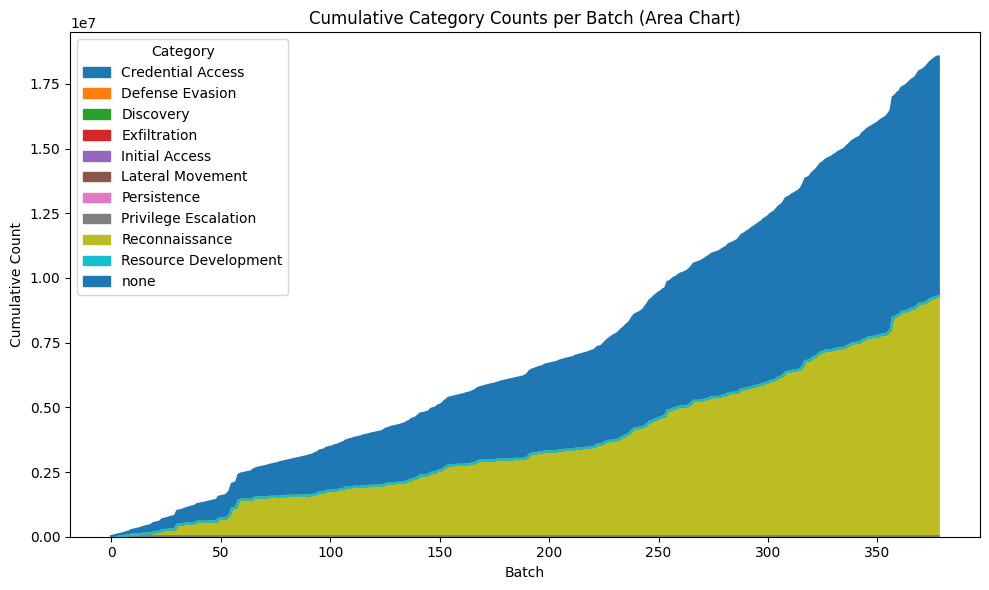

In [46]:
uwf22_shuffled = database_to_df(UWF22S(dataset_folder, shuffle_bin_size=0.25, shuffle_every_time=True, shuffle_type="random"))
grouped = uwf22_shuffled.groupby(['batch', 'label_tactic']).size()
plot_area(grouped, "area-randomshuffled-0.25.svg")

/data/Try1/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
Loading UWF22_Shuffled: 100%|██████████| 8/8 [00:16<00:00,  2.09s/it]


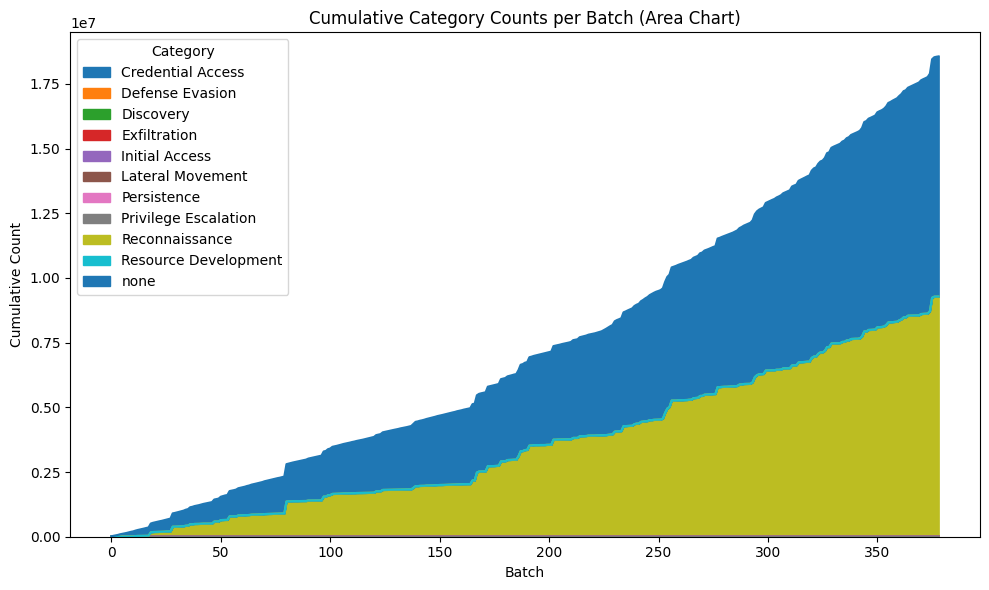

In [47]:
uwf22_shuffled = database_to_df(UWF22S(dataset_folder, shuffle_bin_size=1, shuffle_every_time=True, shuffle_type="random"))
grouped = uwf22_shuffled.groupby(['batch', 'label_tactic']).size()
plot_area(grouped, "area-randomshuffled-1.svg")

/data/Try1/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
Loading UWF22_Shuffled:  25%|██▌       | 2/8 [00:02<00:06,  1.11s/it]

Loading UWF22_Shuffled: 100%|██████████| 8/8 [00:15<00:00,  1.88s/it]


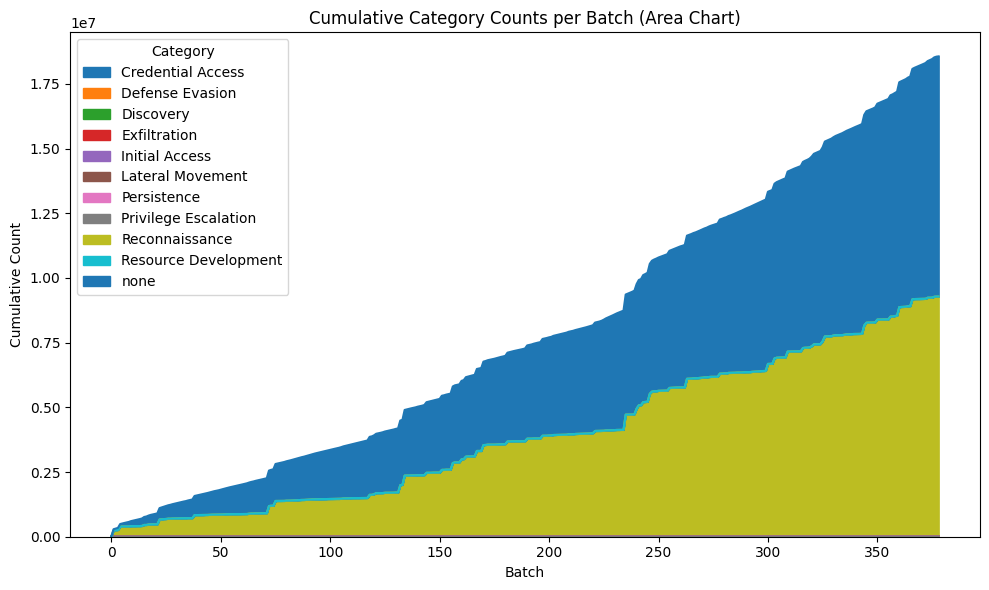

In [48]:
uwf22_shuffled = database_to_df(UWF22S(dataset_folder, shuffle_bin_size=2, shuffle_every_time=True, shuffle_type="random"))
grouped = uwf22_shuffled.groupby(['batch', 'label_tactic']).size()
plot_area(grouped, "area-randomshuffled-2.svg")

/data/Try1/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Loading UWF22_Shuffled: 100%|██████████| 8/8 [00:12<00:00,  1.61s/it]


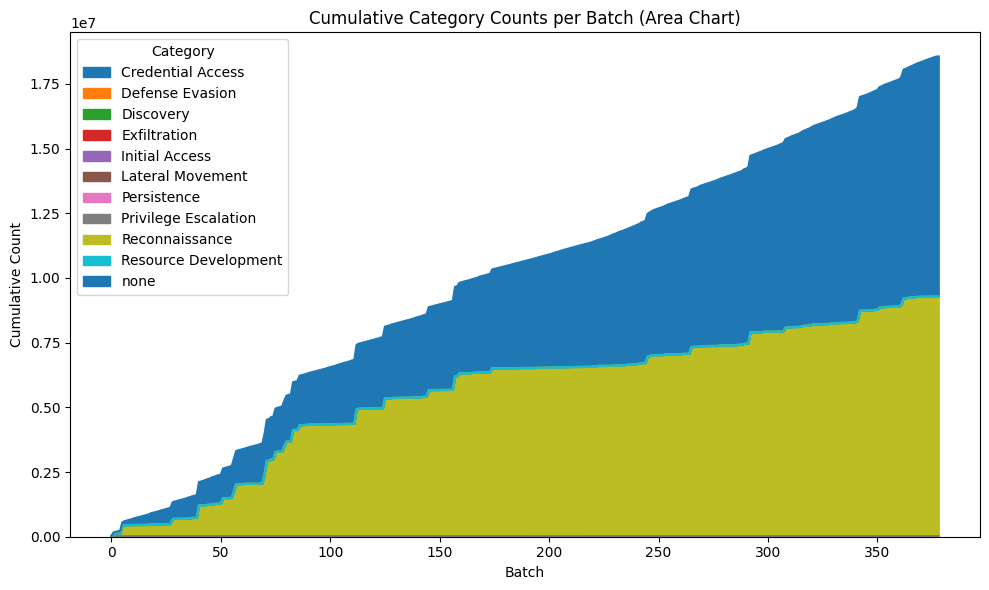

In [49]:
uwf22_shuffled = database_to_df(UWF22S(dataset_folder, shuffle_bin_size=5, shuffle_every_time=True, shuffle_type="random"))
grouped = uwf22_shuffled.groupby(['batch', 'label_tactic']).size()
plot_area(grouped, "area-randomshuffled-5.svg")

/data/Try1/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Loading UWF22_Shuffled: 100%|██████████| 8/8 [00:12<00:00,  1.62s/it]


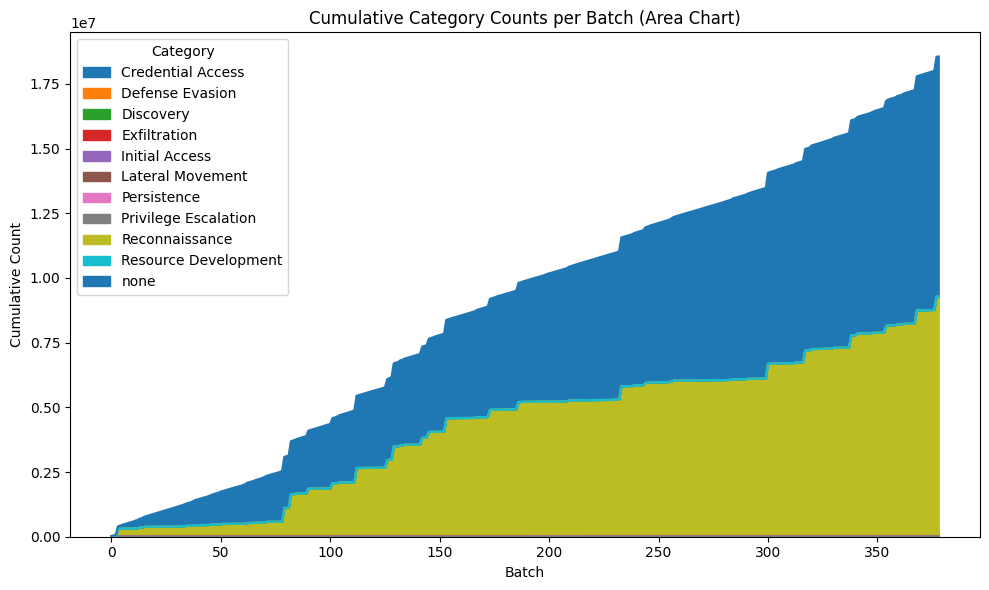

In [50]:
uwf22_shuffled = database_to_df(UWF22S(dataset_folder, shuffle_bin_size=10, shuffle_every_time=True, shuffle_type="random"))
grouped = uwf22_shuffled.groupby(['batch', 'label_tactic']).size()
plot_area(grouped, "area-randomshuffled-10.svg")

/data/Try1/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
Loading UWF22_Shuffled: 100%|██████████| 8/8 [00:13<00:00,  1.70s/it]


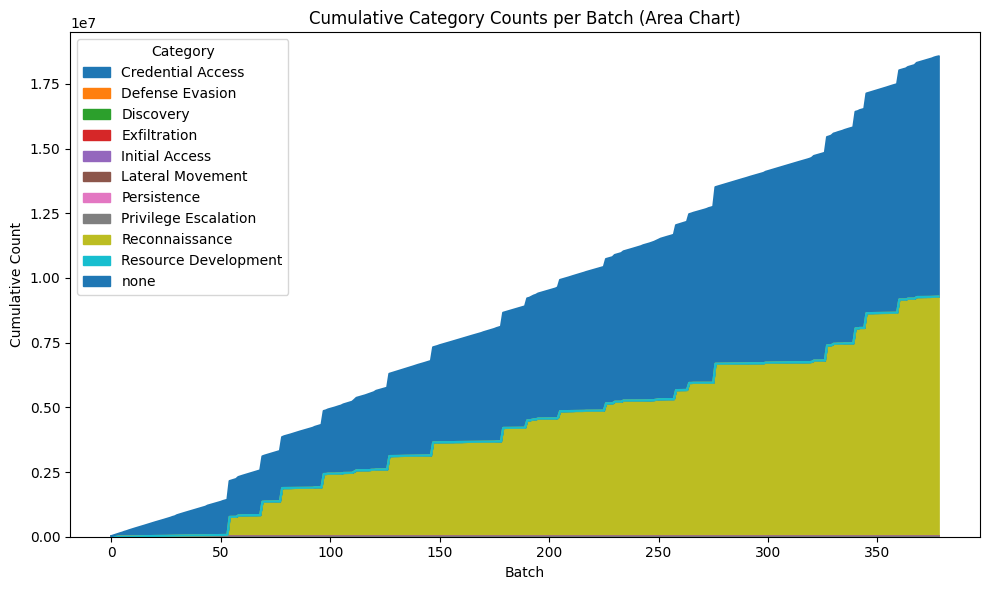

In [54]:
uwf22_shuffled = database_to_df(UWF22S(dataset_folder, shuffle_bin_size=20, shuffle_every_time=True, shuffle_type="random"))
grouped = uwf22_shuffled.groupby(['batch', 'label_tactic']).size()
plot_area(grouped, "area-randomshuffled-20.svg")

/data/Try1/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
Loading UWF22_Shuffled: 100%|██████████| 8/8 [00:14<00:00,  1.79s/it]


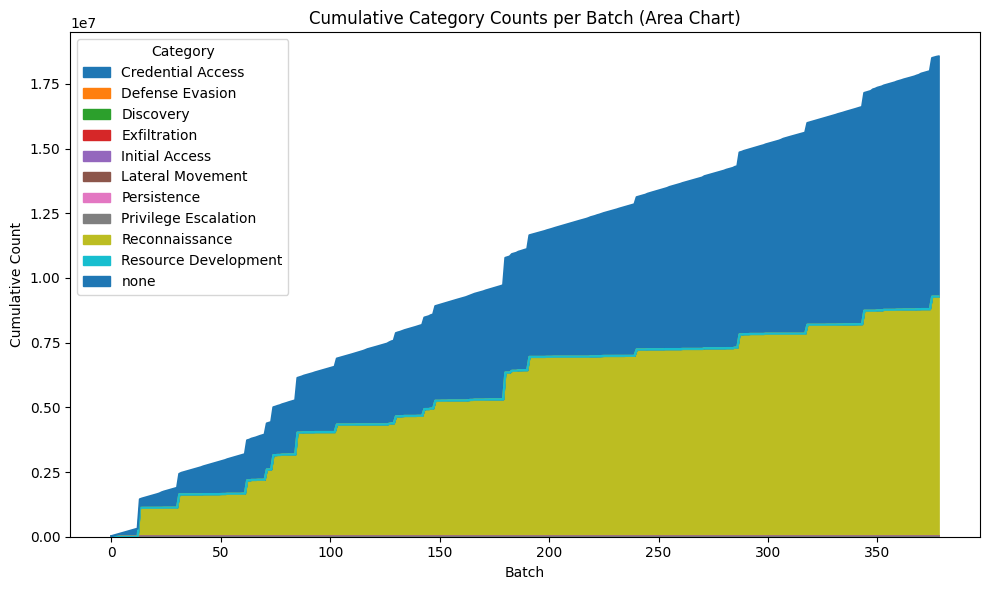

In [52]:
uwf22_shuffled = database_to_df(UWF22S(dataset_folder, shuffle_bin_size=20*5, shuffle_every_time=True, shuffle_type="random"))
grouped = uwf22_shuffled.groupby(['batch', 'label_tactic']).size()
plot_area(grouped, "area-randomshuffled-100.svg")

/data/Try1/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
Loading UWF22_Shuffled: 100%|██████████| 8/8 [00:15<00:00,  1.91s/it]


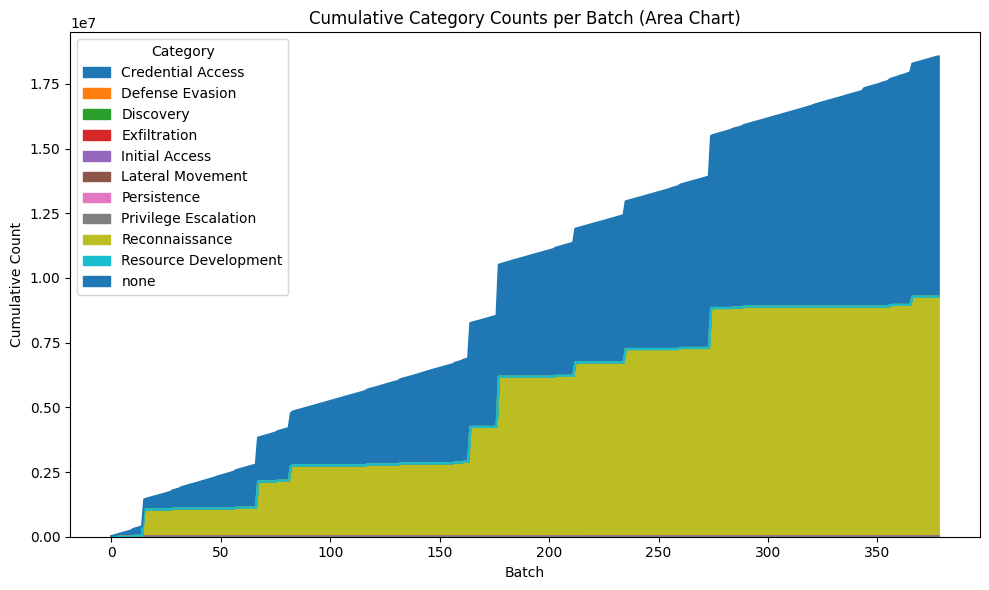

In [53]:
uwf22_shuffled = database_to_df(UWF22S(dataset_folder, shuffle_bin_size=20*20, shuffle_every_time=True, shuffle_type="random"))
grouped = uwf22_shuffled.groupby(['batch', 'label_tactic']).size()
plot_area(grouped, "area-randomshuffled-400.svg")

# Combining all days

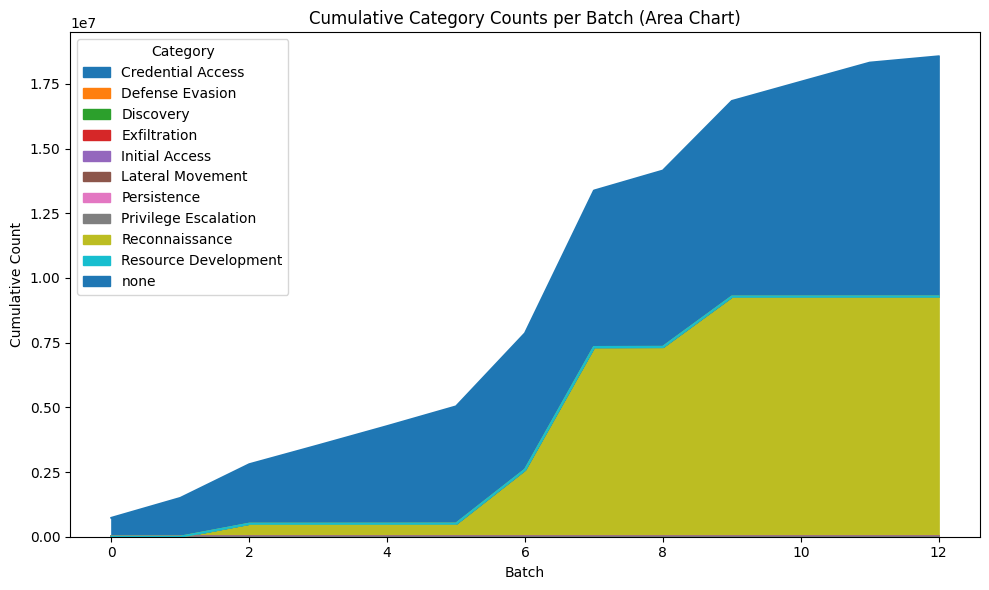

In [20]:
grouped = uwf22s.groupby(['batch', 'label_tactic']).size()
plot_area(grouped)

# Graph unique (unseen) values
This shows per time bin how many new/unseen values have been observed for every time bin.
- x axis -> each time bin
- y axis -> percentage of unique values

*This takes some time*

In [ ]:
import pandas as pd
from tqdm.auto import tqdm

tqdm.pandas()

dataset_folder = "/data/datasets/"
output_folder = "data_stats/"
results = {}

for dataset_name in possible_datasets:
    # The heterogeneous variant is not needed
    if dataset_name == "UWF22h":
        continue

    if dataset_name == "UWF22":
        dataset = UWF22L(dataset_folder)
    elif dataset_name == "UWF22h":
        dataset = UWF22HL(dataset_folder)
    elif dataset_name == "UWF22Fall":
        dataset = UWF22FallL(dataset_folder)
    elif dataset_name == "UWF24":
        dataset = UWF24L(dataset_folder)
    elif dataset_name == "UWF24Fall":
        dataset = UWF24FallL(dataset_folder)
    else:
        raise Exception(f"Dataset {dataset_name} not found")

    dataset.prepare_data()
    dataset.setup(stage="fit")

    count = EventCount(dataset, output_folder)
    keymaps = KeyMapGen(dataset, output_folder)

    for batch, stage in tqdm(dataset.generate_batches(),
                                            f"Extracting data from batches ({dataset.dataset_name})", total=441):
        count.process_batch(batch, stage)
        keymaps.process_batch(batch, stage)

    keymaps.save()
    keymaps.saveplots()
    results[dataset_name] = {
        "dataset": dataset_name,
        "event_count": count.compute(),
        "unique_hosts": int(keymaps.compute()["hosts"].max()),
        "unique_services": int(keymaps.compute()["services"].max())
    }

results = pd.DataFrame(results.values())
results.to_parquet(os.path.join(output_folder, "stats.parquet"))